# Gravity inversion using recipes

In [1]:
import discretize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [4]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [5]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [6]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [7]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-0.2, 0.2]) # g/cc

In [8]:
model = np.zeros(mesh.n_cells)

for prism, density in zip(prisms, densities, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

(<matplotlib.collections.QuadMesh at 0x7fd78cc4c830>,)

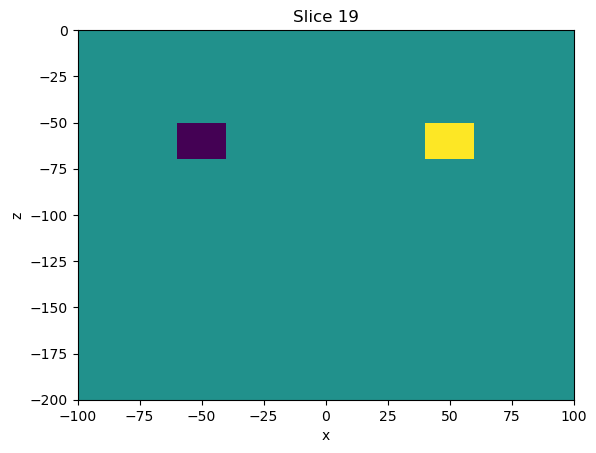

In [9]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [10]:
gz = simulation_simpeg.dpred(model)

In [11]:
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=105).normal(scale=stderr, size=gz.shape)

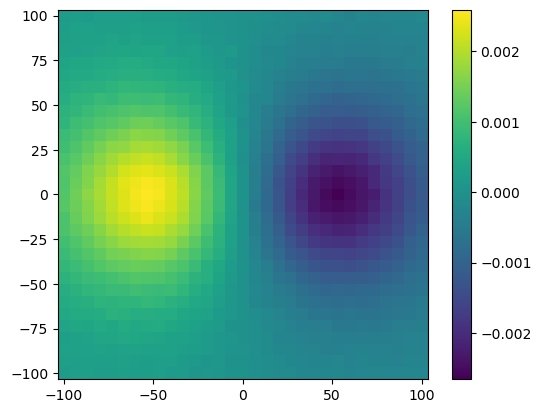

In [12]:
tmp = plt.pcolormesh(*coordinates[:2], gz.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Use inversion recipe

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [13]:
simulation = GravitySimulation(simulation_simpeg)

This `simulation` is _callable_ and has a `jacobian` method, so we can use it with our new framework:

In [14]:
model = np.ones(simulation.n_params)
dpred = simulation(model)

In [15]:
simulation.jacobian(model)

<961x64000 _CustomLinearOperator with dtype=float64>

In [16]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)
data_misfit

φd(m)

In [17]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
smallness = ii.TikhonovZero(
    n_params=simulation.n_params, weights=volume_weights * depth_weights
)
smallness

φs(m)

In [18]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

In [19]:
beta_0, beta_cooling_factor = 1e4, 2.0

inversion_recipe = ii.recipes.simple_inversion(
    data_misfit,
    smallness,
    initial_model=initial_model,
    minimizer=minimizer,
    stopping_criteria=stopping_criteria,
    starting_beta=beta_0,
    beta_cooling_factor=beta_cooling_factor,
)

In [20]:
for model in inversion_recipe:
    continue

Output()